In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('superstore_dataset - segmentation - superstore.csv')
print('Dataset loaded successfully!')
print(f'Shape: {df.shape}')
print(f'\nFirst 5 rows:')
df.head()

Dataset loaded successfully!
Shape: (9994, 21)

First 5 rows:


,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,subcategory,product_name,sales,quantity,discount,profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
df['order_date'] = pd.to_datetime(df['order_date'])

In [ ]:
# 1. Info Dasar
print("\n--- Informasi Dataset ---")
print(f"Jumlah Baris & Kolom: {df.shape}")
print(f"Jumlah Pelanggan Unik: {df['customer_id'].nunique()}")
print(f"Rentang Tanggal: {df['order_date'].min().date()} sampai {df['order_date'].max().date()}")
print(f"Total Penjualan: ${df['sales'].sum():,.2f}")

# 2. Cek Missing Value & Duplikasi
print("\n--- Cek Data Bersih ---")
print(f"Jumlah Null Values:\n{df[['customer_id', 'order_date', 'sales']].isnull().sum()}")
print(f"Jumlah Duplikat: {df.duplicated().sum()}")


# 3. Cek jumlah NaN di 3 kolom itu
print("NaN di kolom penting:")
print(df[['customer_id', 'order_id', 'sales']].isna().sum())

# 4. Cek apakah ada baris yang salah satu dari 3 kolom ini kosong
print("\nAda baris yang bermasalah?")
print(df[['customer_id', 'order_id', 'sales']].isna().any(axis=1).sum(), "baris bermasalah")


--- Informasi Dataset ---
Jumlah Baris & Kolom: (9994, 21)
Jumlah Pelanggan Unik: 793
Rentang Tanggal: 2014-01-03 sampai 2017-12-30
Total Penjualan: $2,297,200.86

--- Cek Data Bersih ---
Jumlah Null Values:
customer_id    0
order_date     0
sales          0
dtype: int64
Jumlah Duplikat: 0
NaN di kolom penting:
customer_id    0
order_id       0
sales          0
dtype: int64

Ada baris yang bermasalah?
0 baris bermasalah


Karena tidak ada yang Nan tidak perlu dropna ya

In [ ]:
# 1. Tentukan Tanggal Referensi (Biasanya H+1 dari data terakhir)
reference_date = df['order_date'].max() + dt.timedelta(days=1)
print(f"\nTanggal Referensi Analisis: {reference_date.date()}")

# 2. Hitung RFM per Customer
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (reference_date - x.max()).days, # Recency
    'order_id': 'nunique',  # Frequency (Hitung Order ID unik)
    'sales': 'sum'          # Monetary
}).reset_index()

# 3. Rename Kolom agar sesuai standar
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

print("\n--- Tabel Hasil Perhitungan RFM (5 Data Teratas) ---")
print(rfm.head())


Tanggal Referensi Analisis: 2017-12-31

--- Tabel Hasil Perhitungan RFM (5 Data Teratas) ---
  Customer ID  Recency  Frequency  Monetary
0    AA-10315      185          5  5563.560
1    AA-10375       20          9  1056.390
2    AA-10480      260          4  1790.512
3    AA-10645       56          6  5086.935
4    AB-10015      416          3   886.156


In [ ]:
# 1. Membuat Label Skor 1-5
r_labels = range(5, 0, -1) # [5, 4, 3, 2, 1] -> Karena Recency kecil itu bagus
f_labels = range(1, 6)     # [1, 2, 3, 4, 5]
m_labels = range(1, 6)     # [1, 2, 3, 4, 5]

# 2. Scoring menggunakan qcut
# Catatan: Untuk Frequency, jika datanya sedikit/banyak duplikat, qcut bisa error.
# Kita gunakan .rank(method='first') untuk menangani nilai yang sama (ties).

rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=r_labels)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=f_labels)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=m_labels)

# 3. Gabungkan menjadi RFM Score String
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# 4. Fungsi Segmentasi Pelanggan (Sesuai Instruksi Soal)
def assign_segment(row):
    r = int(row['R_Score'])
    f = int(row['F_Score'])
    m = int(row['M_Score'])

    if r == 5 and f == 5 and m == 5:
        return "Champions"
    elif r >= 4 and f >= 4:
        return "Loyal Customers"
    elif r <= 2 and f >= 4: # Recency jelek, tapi dulu sering belanja
        return "At Risk"
    elif r <= 2 and f <= 2 and m <= 2:
        return "Hibernating"
    elif r >= 4 and f <= 2: # Baru belanja, tapi jarang (New Customer/Promising)
        return "New/Promising"
    elif r == 3 and f == 3:
        return "Need Attention"
    else:
        return "Others" # Sisa kategori lainnya

rfm['Segment'] = rfm.apply(assign_segment, axis=1)

print("\n--- Contoh Hasil Segmentasi ---")
print(rfm[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Segment']].head())


--- Contoh Hasil Segmentasi ---
  Customer ID  Recency  Frequency  Monetary RFM_Score          Segment
0    AA-10315      185          5  5563.560       225           Others
1    AA-10375       20          9  1056.390       552  Loyal Customers
2    AA-10480      260          4  1790.512       113           Others
3    AA-10645       56          6  5086.935       335   Need Attention
4    AB-10015      416          3   886.156       111      Hibernating


✅ File 'RFM_Analysis_Result.csv' berhasil disimpan! Silakan import ke Power BI.


/tmp/ipython-input-361085460.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')


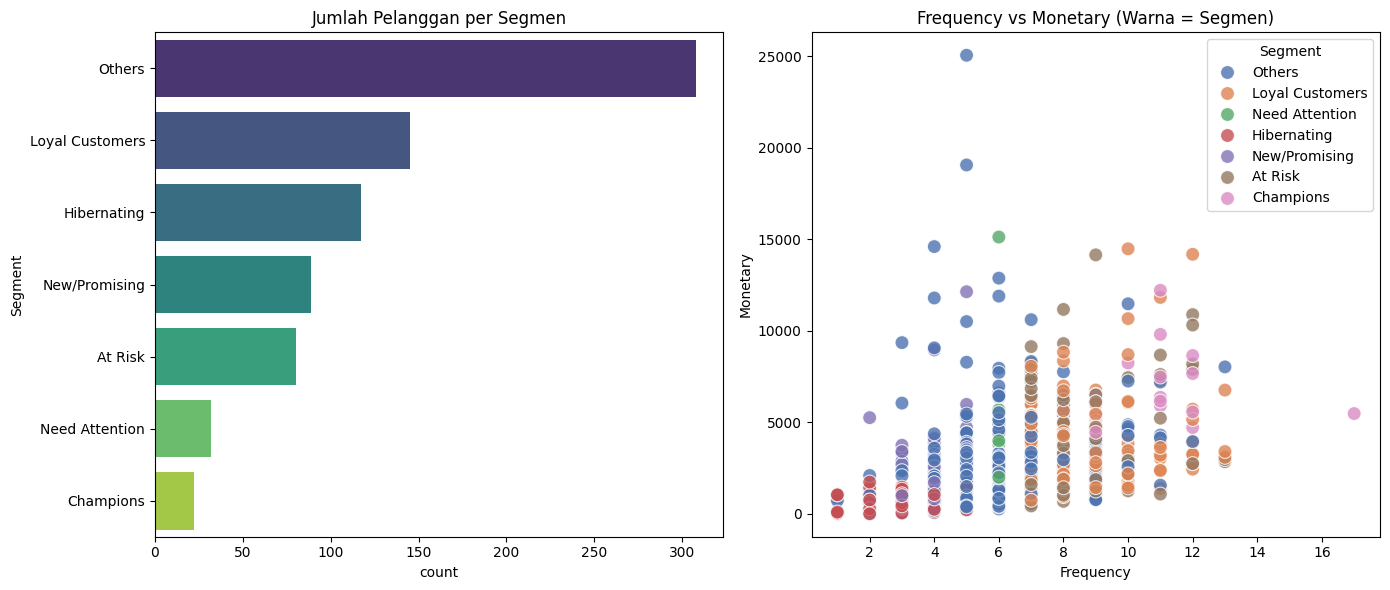

In [ ]:
# 1. Ekspor ke CSV untuk Power BI
rfm.to_csv('RFM_Analysis_Result.csv', index=False)
print("✅ File 'RFM_Analysis_Result.csv' berhasil disimpan! Silakan import ke Power BI.")

# 2. Visualisasi Sederhana di Python (Preview Power BI)
plt.figure(figsize=(14, 6))

# Bar Chart Jumlah Customer
plt.subplot(1, 2, 1)
sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Jumlah Pelanggan per Segmen')

# Scatter Plot Frequency vs Monetary
plt.subplot(1, 2, 2)
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette='deep', s=100, alpha=0.8)
plt.title('Frequency vs Monetary (Warna = Segmen)')

plt.tight_layout()
plt.show()